<a href="https://colab.research.google.com/github/nastyadunaeva/searching_for_anomalies/blob/large-images/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
sys.path.append('/home/nastya/anaconda3/lib/python3.7/site-packages')

In [ ]:
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [1]:
import random

In [2]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [3]:
from matplotlib import pyplot

In [4]:
import numpy as np

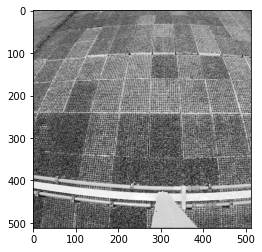

In [5]:
from matplotlib import pyplot
ref_img=Image.open('/content/square_frame02941.png').convert("L")
pyplot.imshow(ref_img, cmap=pyplot.get_cmap('gray'))
pyplot.show()

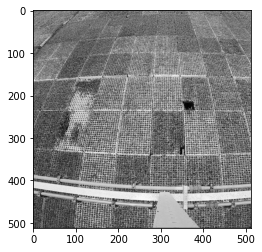

In [6]:
anomalous_img=Image.open('/content/square_frame01981.png').convert("L")
pyplot.imshow(anomalous_img, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [7]:
import numpy as np
anomalous = np.array(anomalous_img)
reference  = np.array(ref_img)

In [8]:
anomalous.shape

(512, 512)

In [ ]:
reference.shape

(512, 512)

In [ ]:
anomalous

array([[126, 143, 116, ..., 115, 130, 141],
       [ 96, 132, 160, ..., 114, 126, 125],
       [122, 133, 136, ..., 104, 150, 128],
       ...,
       [ 65,  63,  91, ...,  33,  44,  61],
       [ 74, 102,  43, ...,  25,  20,  32],
       [ 57,  56,  37, ...,  10,  16,  22]], dtype=uint8)

In [ ]:
reference

array([[152, 147, 132, ...,  46,  33,  19],
       [123, 131, 125, ...,  53,  58,  30],
       [157, 145, 160, ...,  89,  89,  76],
       ...,
       [ 31,  75,  76, ..., 107,  82, 100],
       [ 79,  66,  63, ..., 137, 137, 125],
       [ 38,  35,  41, ...,  32,  71,  74]], dtype=uint8)

In [9]:
# Выделяет из картинки патчи размером sp, линеаризует и возвращает набор этих векторов (точки пространства)
# Патчи не накладываются
def generate_points(matrix, sp):
    points = []
    for i in range(0, matrix.shape[0], sp):
        for j in range(0, matrix.shape[1], sp):
            point = matrix[i:i+sp, j:j+sp]
            point = point.flatten()
            points.append(point)
    return points

In [ ]:
#Проверка generate_points
a = np.array([[1, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]])
generate_points(a, 2)

[array([1, 2, 5, 3]),
 array([0, 0, 0, 4]),
 array([0, 0, 9, 3]),
 array([0, 7, 0, 0])]

In [8]:
# Выделяет из картинки патчи размером sp, линеаризует и возвращает набор этих векторов (точки пространства)
# Патчи накладываются
def generate_points_overlay(matrix, sp):
    points = []
    for i in range(0, matrix.shape[0] - sp + 1):
        for j in range(0, matrix.shape[1] - sp + 1):
            point = matrix[i:i+sp, j:j+sp]
            point = point.flatten()
            points.append(point)
#             point_np = np.array(point)
#             point_reshaped = np.reshape(point_np, (sp,sp))
#             img = Image.fromarray(point_reshaped, 'L')
#             pyplot.imshow(img, cmap=pyplot.get_cmap('gray'))
#             pyplot.show()
            
    return points

In [ ]:
#Проверка generate_points_overlay
arr = np.array([[1, 2, 0, 0, 1],
              [5, 3, 0, 4, 2],
              [0, 0, 0, 7, 9],
              [9, 3, 0, 0, 10]])
p = generate_points_overlay(arr, 3)
p

[array([1, 2, 0, 5, 3, 0, 0, 0, 0]),
 array([2, 0, 0, 3, 0, 4, 0, 0, 7]),
 array([0, 0, 1, 0, 4, 2, 0, 7, 9]),
 array([5, 3, 0, 0, 0, 0, 9, 3, 0]),
 array([3, 0, 4, 0, 0, 7, 3, 0, 0]),
 array([ 0,  4,  2,  0,  7,  9,  0,  0, 10])]

In [ ]:
b = np.array([0,1,2,3])
b.shape
b = np.reshape(b, (2, 2))
b

array([[0, 1],
       [2, 3]])

In [7]:
from scipy.ndimage import convolve

In [ ]:
# Проверка convolve
a = np.array([[1, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]])
k = np.array([[1,1,1],[1,1,0],[1,0,0]])
convolve(a, k, mode='constant', cval=0.0)

array([[11, 10,  7,  4],
       [10,  3, 11, 11],
       [15, 12, 14,  7],
       [12,  3,  7,  0]])

In [6]:
from scipy.ndimage import gaussian_filter 
import scipy.stats as st
import skimage.measure

In [5]:
# Возвращает 2D гауссово ядро
def gaussian_kern(dimension, sigma=1.39):
    x = cv2.getGaussianKernel(dimension,sigma)
    y = cv2.getGaussianKernel(dimension, sigma)
    kernel = x.dot(y.T)
    return kernel

In [ ]:
# Пример ядра
gaussian_kern(5)

array([[0.01191142, 0.02588995, 0.03353671, 0.02588995, 0.01191142],
       [0.02588995, 0.05627285, 0.07289339, 0.05627285, 0.02588995],
       [0.03353671, 0.07289339, 0.09442291, 0.07289339, 0.03353671],
       [0.02588995, 0.05627285, 0.07289339, 0.05627285, 0.02588995],
       [0.01191142, 0.02588995, 0.03353671, 0.02588995, 0.01191142]])

In [10]:
# Возвращает кортеж из 4 картинок разных масштабов
def multiscale_decomposition(u, v):
    sigma = 1.39 # Чему равна сигма?
    kernlen = 13 # Зависит от того что такое сигма
    gauss = gaussian_kern(kernlen)
    u0 = u
    v0 = v
    
    u1 = convolve(u0, gauss)
    u1 = skimage.measure.block_reduce(u1, (2,2), np.max)
    v1 = convolve(v0, gauss)
    v1 = skimage.measure.block_reduce(v1, (2,2), np.max)
    
    u2 = convolve(u1, gauss)
    u2 = skimage.measure.block_reduce(u2, (2,2), np.max)
    v2 = convolve(v1, gauss)
    v2 = skimage.measure.block_reduce(v2, (2,2), np.max)
    
    u3 = convolve(u2, gauss)
    u3 = skimage.measure.block_reduce(u3, (2,2), np.max)
    v3 = convolve(v2, gauss)
    v3 = skimage.measure.block_reduce(v3, (2,2), np.max)
    return (u0, u1, u2, u3, v0, v1, v2, v3)

In [11]:
# Возвращает кортеж из 4 картинок разных масштабов для одной картинки
def multiscale_decomposition_single(u):
    sigma = 1.39 # Чему равна сигма?
    kernlen = 13 # Зависит от того что такое сигма
    gauss = gaussian_kern(kernlen)
    u0 = u
    
    u1 = convolve(u0, gauss)
    u1 = skimage.measure.block_reduce(u1, (2,2), np.max)
    
    u2 = convolve(u1, gauss)
    u2 = skimage.measure.block_reduce(u2, (2,2), np.max)
    
    u3 = convolve(u2, gauss)
    u3 = skimage.measure.block_reduce(u3, (2,2), np.max)

    return (u0, u1, u2, u3)

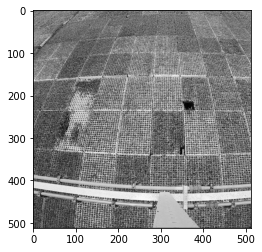

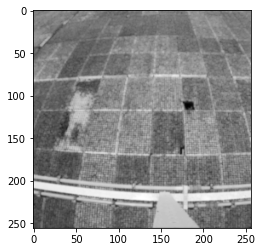

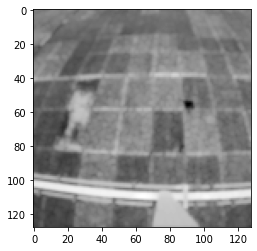

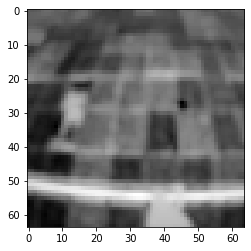

In [ ]:
# Проверка multiscale_decomposition
u_0, u_1, u_2, u_3, v_0, v_1, v_2, v_3 = multiscale_decomposition(anomalous, reference)
i = 0
for u in (u_0, u_1, u_2, u_3):
    img = Image.fromarray(u, 'L')
    pyplot.imshow(img, cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    #name = "scale" + str(i)
    #img.save(name, format="png")
    i = i + 1

In [12]:
!pip install vptree

  Created wheel for vptree: filename=vptree-1.2-py3-none-any.whl size=4394 sha256=ae6d40899dcb1b1f27fb8d601e2d7826961824e655a6602428e37c48d3e3cbb7
  Stored in directory: /root/.cache/pip/wheels/c9/21/cd/62eb42b147e7d391e8bbea7efcdac5aa5ad6f263ed78aebf34
Successfully built vptree


In [13]:
import vptree

In [14]:
#Евклидово расстояние
def euclidean(p1, p2):
  return np.sqrt(np.sum(np.power(p2 - p1, 2)))

In [15]:
import math

In [16]:
# реконструированный патч
def reconstruct(dist, patches, n, h, sp):
    denominator = 0.0
    nomenator = np.zeros((1, sp*sp))
    for i in range(0,n):
        patch = patches[i][:]
        patch = np.reshape(patch, (1,sp*sp))
        nomenator = nomenator + patch * math.exp(-(float(dist[i]) ** 2)/(h * h))
        
        denominator = denominator + math.exp(-(float(dist[i]) ** 2)/(h * h))
    result = nomenator / denominator # размер (1, sp^2)
#     result_im = np.reshape(result, (sp,sp))
#     img = Image.fromarray(result_im, 'L')
#     pyplot.imshow(result_im, cmap=pyplot.get_cmap('gray'))
#     pyplot.show()
    return result

In [17]:
# Собирает из накладывающихся патчей картинку
def image_from_patches(patches, u_width, u_height, sp):
    image = np.zeros((u_height, u_width))
    k = 0;
    for i in range(0, u_height, sp):
        for j in range(0, u_width, sp):
            patch = np.reshape(patches[k], (sp, sp))
            image[i:i+sp, j:j+sp] = patch
            k = k + 1
    return image


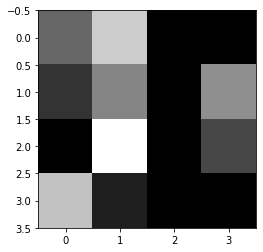

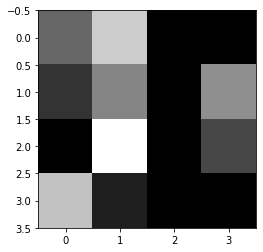

In [ ]:
# Тест image_from_patches
# Разделяем массив на ненакладывающиеся патчи и собирает обратно
image_test = np.array([[100, 200, 0, 0],
              [50, 130, 0, 140],
              [0, 250, 0, 70],
              [190, 30, 0, 0]])
enc_img = Image.fromarray(image_test, 'L')
pyplot.imshow(image_test, cmap=pyplot.get_cmap('gray')) # рисую сразу массив
pyplot.show()

p = generate_points(image_test, 2) # генерируем патчи размера (2,2)

decoded_image = image_from_patches(p, image_test.shape[1], image_test.shape[0], 2) # восстанавливаем картинку по патчам
dec_img = Image.fromarray(decoded_image, 'L')
pyplot.imshow(decoded_image, cmap=pyplot.get_cmap('gray')) # рисую сразу массив
pyplot.show()

In [18]:
def get_u_model(patches, u_width, u_height, sp):
    u_model = np.zeros((u_height, u_width))
    #print(len(patches))
    k = 0
    for i in range(u_height - sp + 1):
        for j in range(u_width - sp + 1):
            #print(k)
            patch = np.reshape(patches[k], (sp, sp))
            u_model[i:i+sp, j:j+sp] += patch
            k = k + 1
    for i in range(u_height):
        for j in range(u_width):
            u_model[i][j] /= (min(i+1, u_height-i, sp) * min(j+1, u_width-j, sp))
    return u_model

In [ ]:
a = np.array([[1, 2, 0, 0, 1],
              [5, 3, 0, 4, 1],
              [0, 0, 0, 7, 1],
              [9, 3, 0, 0, 1]])
points_a = generate_points_overlay(a, 2)
get_u_model(points_a, 5, 4, 2)

array([[1., 2., 0., 0., 1.],
       [5., 3., 0., 4., 1.],
       [0., 0., 0., 7., 1.],
       [9., 3., 0., 0., 1.]])

In [19]:
# С усреднением наложившихся патчей
def compute_residual(u, v, n, h, sp):
    points_u = generate_points_overlay(u, sp)
    points_v = generate_points_overlay(v, sp)
    num_of_points = len(points_u)
    print(num_of_points)
    reconstructed_patches = []
    tree = vptree.VPTree(points_v, euclidean)
    i = 0
    for patch in points_u:
        
        neighbors = tree.get_n_nearest_neighbors(patch, n) #Считаем что u никогда не равно v, возвращает список кортежей (расстояние, точка)
        if (len(neighbors) != n):
            extra_neighbor = neighbors[0]
            l = len(neighbors)
            for j in range(l, n):
                neighbors.append(extra_neighbor)
                #print(extra_neighbor)
        assert len(neighbors) == n
        dist = np.array([neighbor[0] for neighbor in neighbors])
        dist = np.reshape(dist, (len(neighbors), 1)) # размер (n, 1)
        patches = np.array([neighbor[1] for neighbor in neighbors]) # размер (n, sp^2)
        assert patches.shape == (n, sp*sp)
        
        #patch_reconstr = np.sum(np.exp(-(dist ** 2) / (h*h)) * patches, axis=0) / np.sum(np.exp(-(dist ** 2) / (h*h)))
        
        reconstructed_patch = reconstruct(dist, patches, n, h, sp)
        reconstructed_patches.append(reconstructed_patch)
        
    u_model = get_u_model(reconstructed_patches, u.shape[1], u.shape[0], sp)
    #u_model = image_from_patches(reconstructed_patches, u.shape[1], u.shape[0], sp)
    return u_model - u

In [59]:
# Выбираем соседей из множества патчей из разных изображений
# На вход подается множество патчей, случайно выбранных из нескольких изображений - random_patches
def compute_residual_from_multiple(u, random_patches, n, h, sp):
    points_u = generate_points_overlay(u, sp)
    num_of_points = len(points_u)
    print(num_of_points)
    reconstructed_patches = []
    tree = vptree.VPTree(random_patches, euclidean)
    i = 0
    for patch in points_u:

        neighbors = tree.get_n_nearest_neighbors(patch, n) #Считаем что u никогда не равно v, возвращает список кортежей (расстояние, точка)
        if (len(neighbors) != n):
            extra_neighbor = neighbors[0]
            l = len(neighbors)
            for j in range(l, n):
                neighbors.append(extra_neighbor)
                #print(extra_neighbor)
        assert len(neighbors) == n
        dist = np.array([neighbor[0] for neighbor in neighbors])
        dist = np.reshape(dist, (len(neighbors), 1)) # размер (n, 1)
        patches = np.array([neighbor[1] for neighbor in neighbors]) # размер (n, sp^2)
        assert patches.shape == (n, sp*sp)
        
        #patch_reconstr = np.sum(np.exp(-(dist ** 2) / (h*h)) * patches, axis=0) / np.sum(np.exp(-(dist ** 2) / (h*h)))
        
        reconstructed_patch = reconstruct(dist, patches, n, h, sp)
        reconstructed_patches.append(reconstructed_patch)
        
    u_model = get_u_model(reconstructed_patches, u.shape[1], u.shape[0], sp)
    #u_model = image_from_patches(reconstructed_patches, u.shape[1], u.shape[0], sp)
    return u_model - u

In [21]:
# Без усреднения и без наложения патчей
def compute_residual_not_overlay(u, v, n, h, sp):
    points_u = generate_points(u, sp)
    points_v = generate_points(v, sp)
    num_of_points = len(points_u)
    print(num_of_points)
    reconstructed_patches = []
    tree = vptree.VPTree(points_v, euclidean)
    i = 0
    for patch in points_u:
        
        neighbors = tree.get_n_nearest_neighbors(patch, n) #Считаем что u никогда не равно v, возвращает список кортежей (расстояние, точка)
        if (len(neighbors) != n):
            extra_neighbor = neighbors[0]
            l = len(neighbors)
            for j in range(l, n):
                neighbors.append(extra_neighbor)
                #print(extra_neighbor)
        assert len(neighbors) == n
        dist = np.array([neighbor[0] for neighbor in neighbors])
        dist = np.reshape(dist, (len(neighbors), 1)) # размер (n, 1)
        patches = np.array([neighbor[1] for neighbor in neighbors]) # размер (n, sp^2)
        assert patches.shape == (n, sp*sp)
        
        #reconstructed_patch = np.sum(np.exp(-(dist ** 2) / (h*h)) * patches, axis=0) / np.sum(np.exp(-(dist ** 2) / (h*h)))
        
        reconstructed_patch = reconstruct(dist, patches, n, h, sp)
        reconstructed_patches.append(reconstructed_patch)
        
    #u_model = get_u_model(reconstructed_patches, u.shape[1], u.shape[0], sp)
    u_model = image_from_patches(reconstructed_patches, u.shape[1], u.shape[0], sp)
    return u_model - u

In [27]:
import time

3249


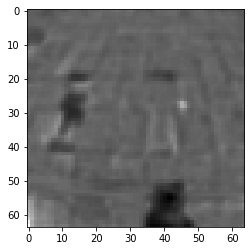

In [ ]:
# С усреднением наложившихся патчей
residual = compute_residual(u_3, v_3, 16, 10, 8)
img = Image.fromarray(residual, 'L')
pyplot.imshow(residual, cmap=pyplot.get_cmap('gray'))
pyplot.show()

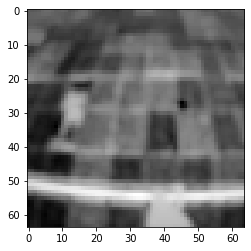

In [ ]:
pyplot.imshow(u_3, cmap=pyplot.get_cmap('gray'))
pyplot.show()

14641


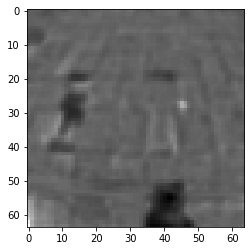

In [ ]:
residual2 = compute_residual(u_2, v_2, 16, 10, 8)
img = Image.fromarray(residual2, 'L')
pyplot.imshow(residual, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [22]:
# Возвращает картинку с ауссовым шумом 
def gauss_noise(u_width, u_height, mean, std):
    samples = np.random.normal(mean, std, size=u_width * u_height)
    image = np.reshape(samples, (u_height, u_width))
    return image

In [23]:
# Возвращает лучшие параметры гауссового шума для картинки u
def fit(u):
    min_dist = 10000000
    best_std = 0
    best_mean = 0
    for mean in range(-10, 180):
        for std in np.linspace(0.01, 10, 1000):
            img = gauss_noise(u.shape[1], u.shape[0], mean, std)
            dist = euclidean(img, u)
            if dist < min_dist:
                min_dist = dist
                best_mean = mean
                best_std = std
    return (best_mean, best_std, min_dist)

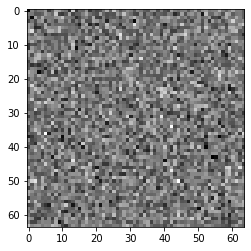

-2
0.36000000000000004
833.8621995093015


In [ ]:
# Шум, близкий к residual(u_3)
best_mean_3, best_std_3, min_dist_3 = fit(residual)
gauss_3 = gauss_noise(residual.shape[1], residual.shape[0], best_mean_3, best_std_3)
pyplot.imshow(gauss_3, cmap=pyplot.get_cmap('gray'))
pyplot.show()
print(best_mean_3)
print(best_std_3)
print(min_dist_3)

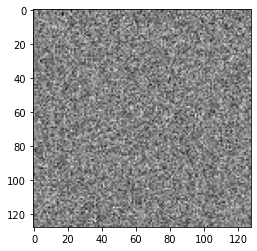

-1
0.38
2054.32505022408


In [ ]:
# Шум, близкий к residual(u_2)
best_mean_2, best_std_2, min_dist_2 = fit(residual2)
img = gauss_noise(residual2.shape[1], residual2.shape[0], best_mean_2, best_std_2)
pyplot.imshow(img, cmap=pyplot.get_cmap('gray'))
pyplot.show()
print(best_mean_2)
print(best_std_2)
print(min_dist_2)

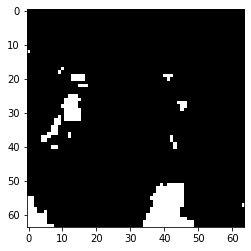

In [ ]:
# красит аномальные пиксели в белый, u_3
# порог 25
detect3 = (abs(residual - gauss_3)>25).astype(int) * 200
pyplot.imshow(detect3, cmap=pyplot.get_cmap('gray'))
pyplot.show()

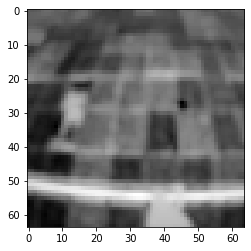

In [ ]:
# Для сравнения, u_3
pyplot.imshow(u_3, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [24]:
# Выбирает случайные патчи из каждого изображения набора
# m - гиперпараметр, число выбранных патчей из каждого изображения 
# Патчи размером sp, линеаризует и возвращает набор этих векторов (точки пространства)
# Возвращается m * size(matrixes)
def generate_random_points(matrixes, sp, m):
    points = []
    for matrix in matrixes:
        for z in range(m):
          i = random.randint(0, matrix.shape[0] - sp)
          j = random.randint(0, matrix.shape[1] - sp)
          point = matrix[i:i+sp, j:j+sp]
          point = point.flatten()
          points.append(point)
            
    return points

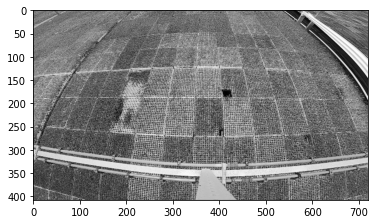

In [38]:
anom_img=Image.open('/content/compressed_frame01981.png').convert("L")
pyplot.imshow(anom_img, cmap=pyplot.get_cmap('gray'))
pyplot.show()

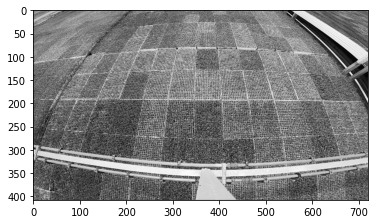

In [39]:
ref_img1=Image.open('/content/compressed_frame02941.png').convert("L")
pyplot.imshow(ref_img1, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [41]:
ref_img2=Image.open('/content/compressed_frame01141.png').convert("L")

In [42]:
ref_img3=Image.open('/content/compressed_frame04351.png').convert("L")

In [43]:
ref_img4=Image.open('/content/compressed_frame06631.png').convert("L")

In [44]:
ref_img5=Image.open('/content/compressed_frame08221.png').convert("L")

In [45]:
anom = np.array(anom_img)
anom0, anom1, anom2, anom3 = multiscale_decomposition_single(anom) 

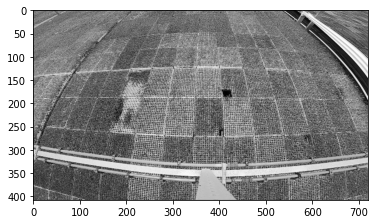

In [46]:
convolved_img = Image.fromarray(anom0, 'L')
pyplot.imshow(convolved_img, cmap=pyplot.get_cmap('gray'))
pyplot.show()

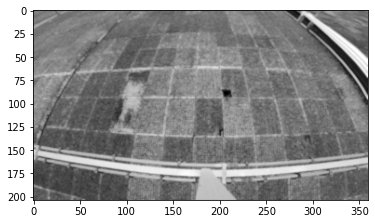

In [ ]:
convolved_img1 = Image.fromarray(anom1, 'L')
pyplot.imshow(convolved_img1, cmap=pyplot.get_cmap('gray'))
pyplot.show()

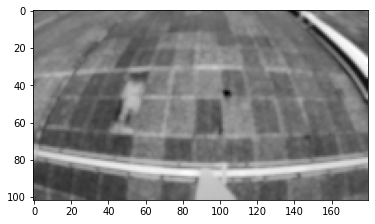

In [ ]:
convolved_img2 = Image.fromarray(anom2, 'L')
pyplot.imshow(convolved_img2, cmap=pyplot.get_cmap('gray'))
pyplot.show()

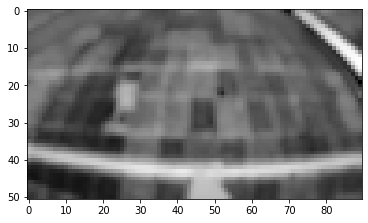

In [ ]:
convolved_img3 = Image.fromarray(anom3, 'L')
pyplot.imshow(convolved_img3, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [47]:
ref1 = np.array(ref_img1)
ref2 = np.array(ref_img2)
ref3 = np.array(ref_img3)
ref4 = np.array(ref_img4)
ref5 = np.array(ref_img5)
ref00, ref01, ref02, ref1_3 = multiscale_decomposition_single(ref1)
ref10, ref11, ref12, ref2_3 = multiscale_decomposition_single(ref2)
ref20, ref21, ref22, ref3_3 = multiscale_decomposition_single(ref3)
ref40, ref41, ref42, ref4_3 = multiscale_decomposition_single(ref4)
ref50, ref51, ref52, ref5_3 = multiscale_decomposition_single(ref5)

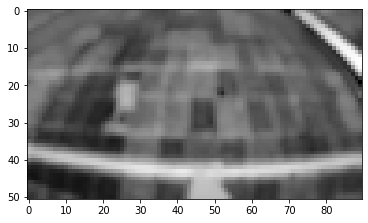

In [ ]:
ffffffff = Image.fromarray(anom3, 'L')
pyplot.imshow(ffffffff, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [48]:
images_ref = []
images_ref.append(ref1_3)
images_ref.append(ref2_3)
images_ref.append(ref3_3)
images_ref.append(ref4_3)
images_ref.append(ref5_3)

In [49]:
# Используем несколько картинок из датасета, из каждой по 800 патчей
patches = generate_random_points(images_ref, 8, 800)
residual = compute_residual_from_multiple(anom3, patches, 16, 10, 8)
img = Image.fromarray(residual, 'L')
pyplot.imshow(residual, cmap=pyplot.get_cmap('gray'))
pyplot.show()

3652
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 64)
(16, 

KeyboardInterrupt: ignored

In [51]:
len(patches)

4000

3652


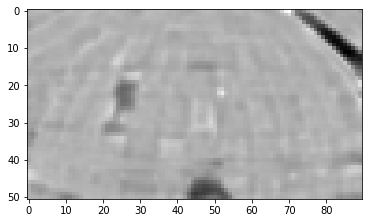

In [ ]:
residual2 = compute_residual(anom3, ref1_3, 16, 10, 8)
img = Image.fromarray(residual2, 'L')
pyplot.imshow(residual2, cmap=pyplot.get_cmap('gray'))
pyplot.show()

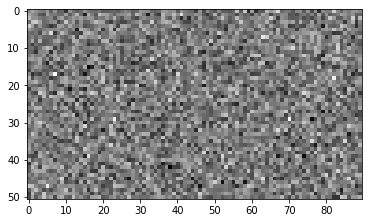

-2
0.36000000000000004
903.757789300698


In [ ]:
best_mean_unsupervised, best_std_unsupervised, min_dist_unsupervised = fit(residual)
gauss_unsupervised = gauss_noise(residual.shape[1], residual.shape[0], best_mean_unsupervised, best_std_unsupervised)
pyplot.imshow(gauss_unsupervised, cmap=pyplot.get_cmap('gray'))
pyplot.show()
print(best_mean_unsupervised)
print(best_std_unsupervised)
print(min_dist_unsupervised)

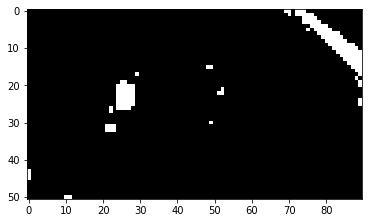

In [ ]:
detect_unsupervised = (abs(residual - gauss_unsupervised)>25).astype(int) * 200
pyplot.imshow(detect_unsupervised, cmap=pyplot.get_cmap('gray'))
pyplot.show()

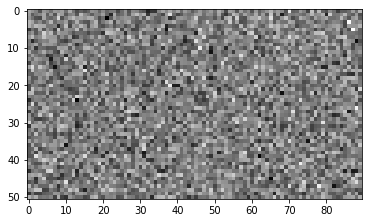

-3
0.34
1022.3064946101169


In [ ]:
best_mean_supervised, best_std_supervised, min_dist_supervised = fit(residual2)
gauss_supervised = gauss_noise(residual2.shape[1], residual2.shape[0], best_mean_supervised, best_std_supervised)
pyplot.imshow(gauss_supervised, cmap=pyplot.get_cmap('gray'))
pyplot.show()
print(best_mean_supervised)
print(best_std_supervised)
print(min_dist_supervised)

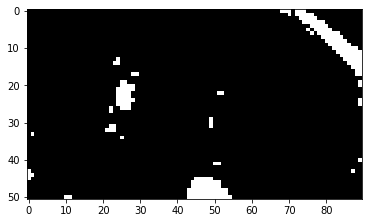

In [ ]:
detect_supervised = (abs(residual2 - gauss_supervised)>25).astype(int) * 200
pyplot.imshow(detect_supervised, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [ ]:
X,Y2 = np.meshgrid(range(anom3.shape[1]), range(anom3.shape[0]))
Z = np.zeros((anom3.shape[0], anom3.shape[1]))
Z.shape

(51, 90)

In [ ]:
Y = np.zeros((Y2.shape[0], Y2.shape[1]))
count = Y2.shape[0] - 1
for row in Y2:
  Y[count] = row
  count -= 1

In [ ]:
for i in range(anom3.shape[0]):
  for j in range(anom3.shape[1]):
    Z[i][j] = anom3[i][j] / 255


(-4.45, 93.45, -2.5, 52.5)

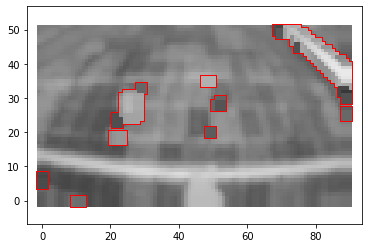

In [ ]:
selected = detect_unsupervised>0.5

info = dict(marker='s',vmin=0,vmax=1)
fig,ax = plt.subplots()
plt.scatter(X.ravel(),Y.ravel(), 100,c=Z.ravel(), cmap=pyplot.get_cmap('gray') ,**info)
plt.scatter(X[selected].ravel(),Y[selected].ravel(),150,c='r',marker='s', cmap=pyplot.get_cmap('gray'))
plt.scatter(X[selected].ravel(),Y[selected].ravel(),100,c=Z[selected].ravel(), cmap=pyplot.get_cmap('gray'),**info)
ax.axis('equal')

In [ ]:
X_supervised,Y2_supervised = np.meshgrid(range(anom3.shape[1]), range(anom3.shape[0]))
Z_supervised = np.zeros((anom3.shape[0], anom3.shape[1]))
Z_supervised.shape

(51, 90)

In [ ]:
Y_supervised = np.zeros((Y2_supervised.shape[0], Y2_supervised.shape[1]))
count = Y2_supervised.shape[0] - 1
for row in Y2_supervised:
  Y_supervised[count] = row
  count -= 1

In [ ]:
for i in range(anom3.shape[0]):
  for j in range(anom3.shape[1]):
    Z_supervised[i][j] = anom3[i][j] / 255

(-4.45, 93.45, -2.5, 52.5)

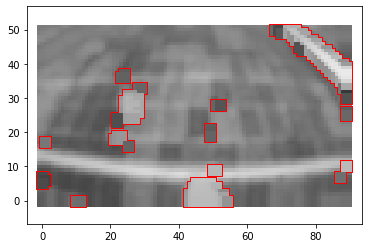

In [ ]:
selected_supervised = detect_supervised>0.5

info_supervised = dict(marker='s',vmin=0,vmax=1)
fig,ax = plt.subplots()
plt.scatter(X_supervised.ravel(),Y_supervised.ravel(), 100,c=Z_supervised.ravel(), cmap=pyplot.get_cmap('gray') ,**info_supervised)
plt.scatter(X_supervised[selected_supervised].ravel(),Y_supervised[selected_supervised].ravel(),150,c='r',marker='s', cmap=pyplot.get_cmap('gray'))
plt.scatter(X_supervised[selected_supervised].ravel(),Y_supervised[selected_supervised].ravel(),100,c=Z_supervised[selected_supervised].ravel(), cmap=pyplot.get_cmap('gray'),**info_supervised)
ax.axis('equal')

In [ ]:
X_sup,Y2_sup= np.meshgrid(range(anom.shape[1]), range(anom.shape[0]))
Z_sup = np.zeros((anom0.shape[0], anom0.shape[1]))
Z_sup.shape

(408, 720)

In [ ]:
Y2_sup

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [405, 405, 405, ..., 405, 405, 405],
       [406, 406, 406, ..., 406, 406, 406],
       [407, 407, 407, ..., 407, 407, 407]])

In [ ]:
Y_sup = np.zeros((Y2_sup.shape[0], Y2_sup.shape[1]))
count = Y2_sup.shape[0] - 1
for row in Y2_sup:
  Y_sup[count] = row
  count -= 1

In [ ]:
Y_sup

array([[407., 407., 407., ..., 407., 407., 407.],
       [406., 406., 406., ..., 406., 406., 406.],
       [405., 405., 405., ..., 405., 405., 405.],
       ...,
       [  2.,   2.,   2., ...,   2.,   2.,   2.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [ ]:
for i in range(anom0.shape[0]):
  for j in range(anom0.shape[1]):
    Z_sup[i][j] = anom0[i][j] / 255

In [ ]:
Z_sup

array([[0.59607843, 0.51372549, 0.43137255, ..., 0.36470588, 0.5372549 ,
        0.61960784],
       [0.44705882, 0.45882353, 0.45490196, ..., 0.54509804, 0.4       ,
        0.34117647],
       [0.42352941, 0.45490196, 0.48235294, ..., 0.49019608, 0.58039216,
        0.65098039],
       ...,
       [0.34509804, 0.30980392, 0.46666667, ..., 0.45490196, 0.57254902,
        0.73333333],
       [0.37254902, 0.25490196, 0.30980392, ..., 0.59215686, 0.49803922,
        0.31764706],
       [0.42352941, 0.33333333, 0.21176471, ..., 0.59607843, 0.36862745,
        0.1254902 ]])

In [ ]:
selected_small = detect_supervised>0.5
selected_sup = np.zeros((anom0.shape[0], anom0.shape[1]), dtype=bool)
for i in range(anom0.shape[0]):
  for j in range(anom0.shape[1]):
    if (selected_small[i//8][j//8] == True):
      selected_sup[i][j] = True

In [ ]:
selected_small_un = detect_unsupervised>0.5
selected_unsup = np.zeros((anom0.shape[0], anom0.shape[1]), dtype=bool)
for i in range(anom0.shape[0]):
  for j in range(anom0.shape[1]):
    if (selected_small_un[i//8][j//8] == True):
      selected_unsup[i][j] = True

In [ ]:
selected_unsup.shape

(408, 720)

In [ ]:
selected_sup.shape

(408, 720)

(-35.95, 754.95, -20.35, 427.35)

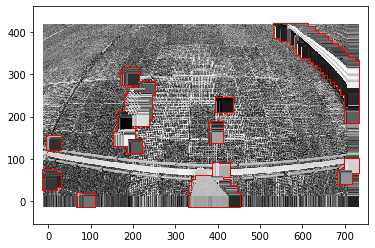

In [ ]:
info_sup = dict(marker='s',vmin=0,vmax=1)
fig,ax = plt.subplots()
plt.scatter(X_sup.ravel(),Y_sup.ravel(), 100,c=Z_sup.ravel(), cmap=pyplot.get_cmap('gray') ,**info_sup)
plt.scatter(X_sup[selected_sup].ravel(),Y_sup[selected_sup].ravel(),150,c='r',marker='s', cmap=pyplot.get_cmap('gray'))
plt.scatter(X_sup[selected_sup].ravel(),Y_sup[selected_sup].ravel(),100,c=Z_sup[selected_sup].ravel(), cmap=pyplot.get_cmap('gray'),**info_sup)
ax.axis('equal')

(-35.95, 754.95, -20.35, 427.35)

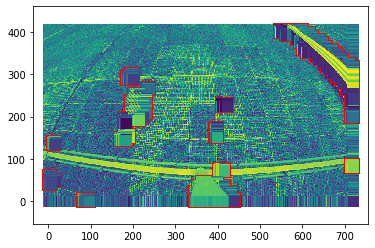

Metrcics

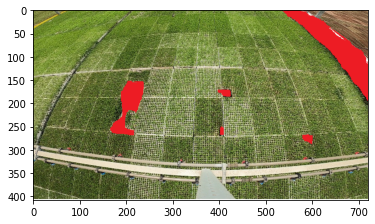

In [ ]:
cut_2=Image.open('/content/01981_anomalies_cut_2.png')
pyplot.imshow(cut_2)
pyplot.show()

In [ ]:
cut = np.array(cut_2)
cut[200][200]

array([237,  28,  36, 255], dtype=uint8)

In [ ]:
red = np.array([237,  28,  36, 255], dtype='uint8')
square_anomalies = 0

In [ ]:
real_detect = np.zeros((anom.shape[0], anom.shape[1]), dtype=bool)

In [ ]:
for i in range(cut.shape[0]):
  for j in range (cut.shape[1]):
    if ((cut[i][j][0] == red[0]) and (cut[i][j][1] == red[1]) and
        (cut[i][j][2] == red[2]) and (cut[i][j][3] == red[3])):
      square_anomalies += 1
      real_detect[i][j] = True

In [ ]:
print('Реальный процент аномалий в оригинальной картинке')
square_anomalies / (anom.shape[0]*anom.shape[1])

Реальный процент аномалий в оригинальной картинке


0.04713371459694989

In [ ]:
print('Процент аномалий в картинке (с учителем)')
supervised_anomalies = 0
for i in range(anom3.shape[0]):
  for j in range (anom3.shape[1]):
    if (detect_supervised[i][j] >100):
      supervised_anomalies += 1

supervised_anomalies / (anom3.shape[0]*anom3.shape[1])

Процент аномалий в картинке (с учителем)


0.046623093681917215

In [ ]:
print('Процент аномалий в картинке (без учителя)')
unsupervised_anomalies = 0
for i in range(anom3.shape[0]):
  for j in range (anom3.shape[1]):
    if (detect_unsupervised[i][j] > 100):
      unsupervised_anomalies += 1

unsupervised_anomalies / (anom3.shape[0]*anom3.shape[1])

Процент аномалий в картинке (без учителя)


0.033115468409586055

In [ ]:
# supervised
TP = 0
FN = 0
TN = 0
FP = 0 
for i in range(anom.shape[0]):
  for j in range(anom.shape[1]):
    if (real_detect[i][j] == True) and (selected_sup[i][j] == True):
      TP += 1
    elif (real_detect[i][j] == True) and (selected_sup[i][j] == False):
      FN += 1
    elif (real_detect[i][j] == False) and (selected_sup[i][j] == False):
      TN += 1
    elif (real_detect[i][j] == False) and (selected_sup[i][j] == True):
      FP += 1

In [ ]:
print('True positive:', TP)
print('False negative:', FN)
print('True negative:', TN)
print('False positive:', FP)

True positive: 7413
False negative: 6433
True negative: 273631
False positive: 6283


In [ ]:
# True positive rate
# supervised

TPR = TP / (TP + FN)
TPR

0.5353892821031345

In [ ]:
# False positive rate
# supervised

FPR = FP / (TN + FP)
FPR

0.022446179898111564

In [ ]:
# unsupervised
TP_u = 0
FN_u = 0
TN_u = 0
FP_u = 0 
for i in range(anom.shape[0]):
  for j in range(anom.shape[1]):
    if (real_detect[i][j] == True) and (selected_unsup[i][j] == True):
      TP_u += 1
    elif (real_detect[i][j] == True) and (selected_unsup[i][j] == False):
      FN_u += 1
    elif (real_detect[i][j] == False) and (selected_unsup[i][j] == False):
      TN_u += 1
    elif (real_detect[i][j] == False) and (selected_unsup[i][j] == True):
      FP_u += 1

In [ ]:
print('True positive:', TP_u)
print('False negative:', FN_u)
print('True negative:', TN_u)
print('False positive:', FP_u)

True positive: 7566
False negative: 6280
True negative: 277752
False positive: 2162


In [ ]:
# True positive rate
# unsupervised

TPR_u = TP_u / (TP_u + FN_u)
TPR_u

0.5464394048822765

In [ ]:
# False positive rate
# unsupervised

FPR_u = FP_u / (TN_u + FP_u)
FPR_u

0.007723800881699379

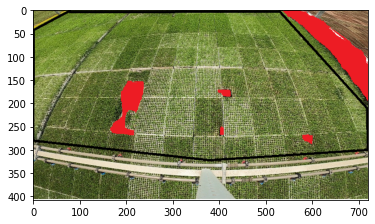

In [ ]:
anom_area=Image.open('/content/01981_anomalies_area.png')
pyplot.imshow(anom_area)
pyplot.show()

In [ ]:
from matplotlib import path

In [ ]:
p = path.Path([(0,529), (212, 719), (300, 719), (322, 381), (280, 0), (41, 0), (0, 79)])

In [ ]:
# supervised
# in area
TP_ar = 0
FN_ar = 0
TN_ar = 0
FP_ar = 0 
for i in range(anom.shape[0]):
  for j in range(anom.shape[1]):
    if (p.contains_point((i, j))):
      if (real_detect[i][j] == True) and (selected_sup[i][j] == True):
        TP_ar += 1
      elif (real_detect[i][j] == True) and (selected_sup[i][j] == False):
        FN_ar += 1
      elif (real_detect[i][j] == False) and (selected_sup[i][j] == False):
        TN_ar += 1
      elif (real_detect[i][j] == False) and (selected_sup[i][j] == True):
        FP_ar += 1

In [ ]:
print('True positive:', TP_ar)
print('False negative:', FN_ar)
print('True negative:', TN_ar)
print('False positive:', FP_ar)

True positive: 2377
False negative: 2228
True negative: 192301
False positive: 829


In [ ]:
# True positive rate
# supervised
# in area

TPR_ar = TP_ar / (TP_ar + FN_ar)
TPR_ar

0.5161780673181324

In [ ]:
# False positive rate
# supervised
# in area

FPR_ar = FP_ar / (TN_ar + FP_ar)
FPR_ar

0.004292445503029048

In [ ]:
# unsupervised
TP_u_ar = 0
FN_u_ar = 0
TN_u_ar = 0
FP_u_ar = 0 
for i in range(anom.shape[0]):
  for j in range(anom.shape[1]):
    if (p.contains_point((i, j))):
      if (real_detect[i][j] == True) and (selected_unsup[i][j] == True):
        TP_u_ar += 1
      elif (real_detect[i][j] == True) and (selected_unsup[i][j] == False):
        FN_u_ar += 1
      elif (real_detect[i][j] == False) and (selected_unsup[i][j] == False):
        TN_u_ar += 1
      elif (real_detect[i][j] == False) and (selected_unsup[i][j] == True):
        FP_u_ar += 1

In [ ]:
print('True positive:', TP_u_ar)
print('False negative:', FN_u_ar)
print('True negative:', TN_u_ar)
print('False positive:', FP_u_ar)

True positive: 2720
False negative: 1885
True negative: 192580
False positive: 550


In [ ]:
# True positive rate
# unsupervised
# in area

TPR_u_ar = TP_u_ar / (TP_u_ar + FN_u_ar)
TPR_u_ar

0.5906623235613464

In [ ]:
# False positive rate
# unsupervised
# in area

FPR_u_ar = FP_u_ar / (TN_u_ar + FP_u_ar)
FPR_u_ar

0.002847822710091648

Working with large images

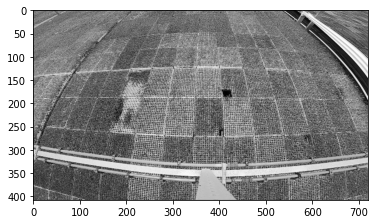

In [25]:
anom_img_large=Image.open('/content/compressed_frame01981.png').convert("L")
pyplot.imshow(anom_img_large, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [26]:
width, height = anom_img_large.size
print(width)
print(height)

720
408


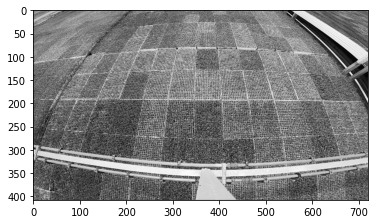

In [27]:
ref_img1_large=Image.open('/content/compressed_frame02941.png').convert("L")
pyplot.imshow(ref_img1_large, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [28]:
ref_img2_large=Image.open('/content/compressed_frame02941.png').convert("L")
ref_img3_large=Image.open('/content/compressed_frame04351.png').convert("L")
ref_img4_large=Image.open('/content/compressed_frame06631.png').convert("L")
ref_img5_large=Image.open('/content/compressed_frame08221.png').convert("L")

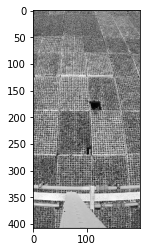

In [29]:
area = (300, 0, 500, 408)
cropped_img = anom_img_large.crop(area)
pyplot.imshow(cropped_img, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [30]:
cropped_img_arr = np.array(cropped_img)
cropped_img_arr.shape

(408, 200)

In [31]:
# число полос, на которые будет разрезано изображение
N_parts = 3

In [32]:
# размер патча
sp = 8

In [33]:
# сколько патчей берем из каждого изображения
limit = 265

In [55]:
# Выбирает случайные патчи из опорного изображения image путем разделения его на полосы
# Полосы размывает
# m - гиперпараметр, число выбранных патчей из полосы 
# n_stripes - число полос на которые изображение будет разрезано
# Патчи размером sp, линеаризует и возвращает набор этих векторов (точки пространства)
# Возвращает m * n_stripes патчей
# не вырезаем сразу патчи, так как картинку надо предварительно размыть, но это надо 
# делать по частям, чтобы не хранить в памяти большую картинку
def generate_points_from_large(image, sp, m, n_stripes):
    points = []
    w, h = image.size
    print('w = ', w, ' h = ', h)
    step = w // n_stripes
    print('step = ', step)
    for stripe in range(n_stripes):
        if (step * (stripe + 1) >= w):
          area = (step * stripe, 0, w, h)
        else:
          area = (step * stripe, 0, step * (stripe + 1), h)
        print('area: ', area)
        cropped_stripe = image.crop(area)

        #pyplot.imshow(cropped_stripe, cmap=pyplot.get_cmap('gray'))
        #pyplot.show()
        
        matrix = np.array(cropped_stripe)
        dim0, dim1, dim2, blurry_matrix = multiscale_decomposition_single(matrix)

        img = Image.fromarray(blurry_matrix, 'L')
        pyplot.imshow(blurry_matrix, cmap=pyplot.get_cmap('gray'))
        pyplot.show()
        for z in range(m):
          i = random.randint(0, blurry_matrix.shape[0] - sp)
          j = random.randint(0, blurry_matrix.shape[1] - sp)
          point = blurry_matrix[i:i+sp, j:j+sp]
          point = point.flatten()
          points.append(point)
            
    return points

In [54]:
# Вычисляет остаточное изображение от полосы
# u - изображение, полоса (с аномалией)
def compute_residual_large(u, random_patches, n, h, sp):
  
    points_u = generate_points_overlay(u, sp)
    num_of_points = len(points_u)
    print(num_of_points)
    reconstructed_patches = []
    tree = vptree.VPTree(random_patches, euclidean)
    i = 0
    for patch in points_u:

        neighbors = tree.get_n_nearest_neighbors(patch, n) #Считаем что u никогда не равно v, возвращает список кортежей (расстояние, точка)
        if (len(neighbors) != n):
            extra_neighbor = neighbors[0]
            l = len(neighbors)
            for j in range(l, n):
                neighbors.append(extra_neighbor)
                #print(extra_neighbor)
        assert len(neighbors) == n
        dist = np.array([neighbor[0] for neighbor in neighbors])
        dist = np.reshape(dist, (len(neighbors), 1)) # размер (n, 1)
        patches = np.array([neighbor[1] for neighbor in neighbors]) # размер (n, sp^2)
        assert patches.shape == (n, sp*sp)
        
        #patch_reconstr = np.sum(np.exp(-(dist ** 2) / (h*h)) * patches, axis=0) / np.sum(np.exp(-(dist ** 2) / (h*h)))
        
        reconstructed_patch = reconstruct(dist, patches, n, h, sp)
        reconstructed_patches.append(reconstructed_patch)
        
    u_model = get_u_model(reconstructed_patches, u.shape[1], u.shape[0], sp)
    #u_model = image_from_patches(reconstructed_patches, u.shape[1], u.shape[0], sp)
    return u_model - u

w =  720  h =  408
step =  240
area:  (0, 0, 240, 408)


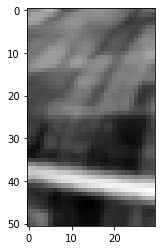

area:  (240, 0, 480, 408)


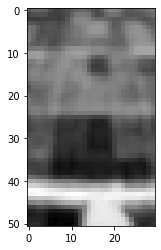

area:  (480, 0, 720, 408)


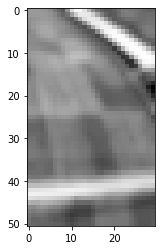

795
w =  720  h =  408
step =  240
area:  (0, 0, 240, 408)


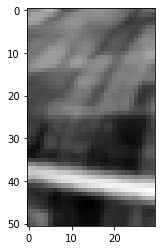

area:  (240, 0, 480, 408)


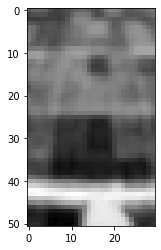

area:  (480, 0, 720, 408)


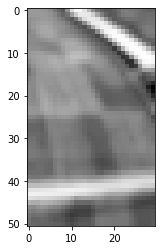

795
w =  720  h =  408
step =  240
area:  (0, 0, 240, 408)


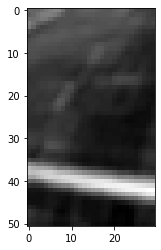

area:  (240, 0, 480, 408)


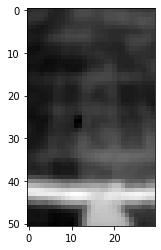

area:  (480, 0, 720, 408)


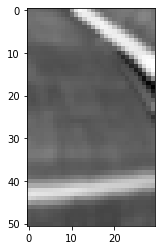

795
w =  720  h =  408
step =  240
area:  (0, 0, 240, 408)


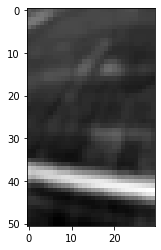

area:  (240, 0, 480, 408)


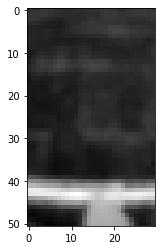

area:  (480, 0, 720, 408)


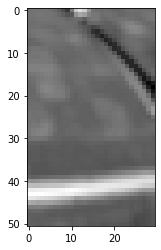

795
w =  720  h =  408
step =  240
area:  (0, 0, 240, 408)


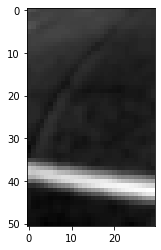

area:  (240, 0, 480, 408)


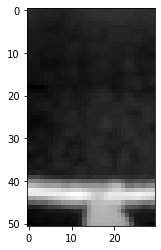

area:  (480, 0, 720, 408)


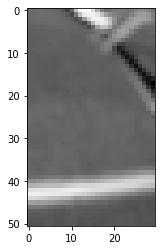

795


In [56]:
# патчи из опорных изображений
patches_from_large = []
for ref_img in [ref_img1_large, ref_img2_large, ref_img3_large, ref_img4_large, ref_img5_large]:
  patches_from_ref = generate_points_from_large(ref_img, sp, limit, N_parts)
  print(len(patches_from_ref))
  patches_from_large.extend(patches_from_ref)

In [57]:
len(patches_from_large)

3975

In [63]:
# обводим на изображении (target_image) аномалии по маске (detection)
def encircle(target_image, detection):
  X,Y2 = np.meshgrid(range(target_image.shape[1]), range(target_image.shape[0]))
  Z = np.zeros((target_image.shape[0], target_image.shape[1]))
  Z.shape

  Y = np.zeros((Y2.shape[0], Y2.shape[1]))
  count = Y2.shape[0] - 1
  for row in Y2:
    Y[count] = row
    count -= 1

  for i in range(target_image.shape[0]):
    for j in range(target_image.shape[1]):
      Z[i][j] = target_image[i][j] / 255

  selected = detection > 0.5

  info = dict(marker='s',vmin=0,vmax=1)
  fig,ax = plt.subplots()
  plt.scatter(X.ravel(),Y.ravel(), 100,c=Z.ravel(), cmap=pyplot.get_cmap('gray') ,**info)
  plt.scatter(X[selected].ravel(),Y[selected].ravel(),150,c='r',marker='s', cmap=pyplot.get_cmap('gray'))
  plt.scatter(X[selected].ravel(),Y[selected].ravel(),100,c=Z[selected].ravel(), cmap=pyplot.get_cmap('gray'),**info)
  ax.axis('equal')

stripe:


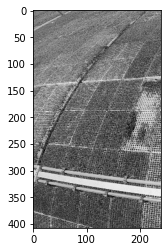

1012
residual:


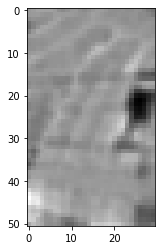

Best mean:  -1
Best std:  0.51
Min distance:  485.22414389261667


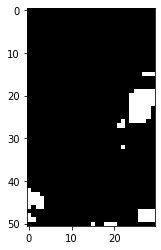

stripe:


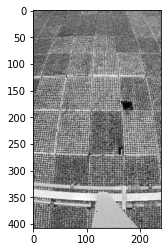

1012
residual:


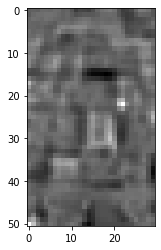

Best mean:  -1
Best std:  0.14
Min distance:  258.2147814617475


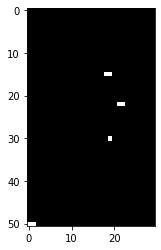

stripe:


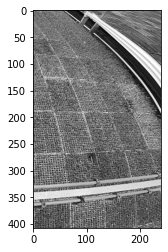

1012
residual:


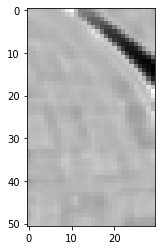

Best mean:  -5
Best std:  0.98
Min distance:  812.3654335494388


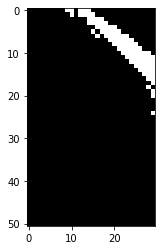

In [68]:
step_anom = width // N_parts
for i in range(N_parts):
    if (step_anom * (i + 1) >= width):
        area = (step_anom * i, 0, width, height)
    else:
        area = (step_anom * i, 0, step_anom * (i + 1), height)
    cropped_stripe_anom = anom_img_large.crop(area)

    print('stripe:')
    pyplot.imshow(cropped_stripe_anom, cmap=pyplot.get_cmap('gray'))
    pyplot.show()
        
    stripe_arr = np.array(cropped_stripe_anom)
    dim00, dim01, dim02, blurry_stripe_anom = multiscale_decomposition_single(stripe_arr)
    residual_stripe = compute_residual_from_multiple(blurry_stripe_anom, patches_from_large, 16, 10, sp)

    print('residual:')
    img = Image.fromarray(residual_stripe, 'L')
    pyplot.imshow(residual_stripe, cmap=pyplot.get_cmap('gray'))
    pyplot.show()

    best_mean_stripe, best_std_stripe, min_dist_stripe = fit(residual_stripe)
    gauss_stripe = gauss_noise(residual_stripe.shape[1], residual_stripe.shape[0], best_mean_stripe, best_std_stripe)
    print('Best mean: ', best_mean_stripe)
    print('Best std: ', best_std_stripe)
    print('Min distance: ', min_dist_stripe)

    detect_stripe = (abs(residual_stripe - gauss_stripe)>25).astype(int) * 200
    pyplot.imshow(detect_stripe, cmap=pyplot.get_cmap('gray'))
    pyplot.show()

    #encircle(blurry_stripe_anom, detect_stripe)

    